In [399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input,Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam 
import tensorflow.keras.backend as K
from pyESN import ESN
import random

In [401]:
# Import data
data = pd.read_csv("./DB/apple_stock.csv")

# Convert 'Date' to datetime and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [403]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.318729,234684800
2014-01-03,19.745001,19.775000,19.301071,19.320715,16.938305,392467600
2014-01-06,19.194643,19.528570,19.057142,19.426071,17.030676,412610800
2014-01-07,19.440001,19.498571,19.211430,19.287144,16.908880,317209200
2014-01-08,19.243214,19.484285,19.238930,19.409286,17.015959,258529600


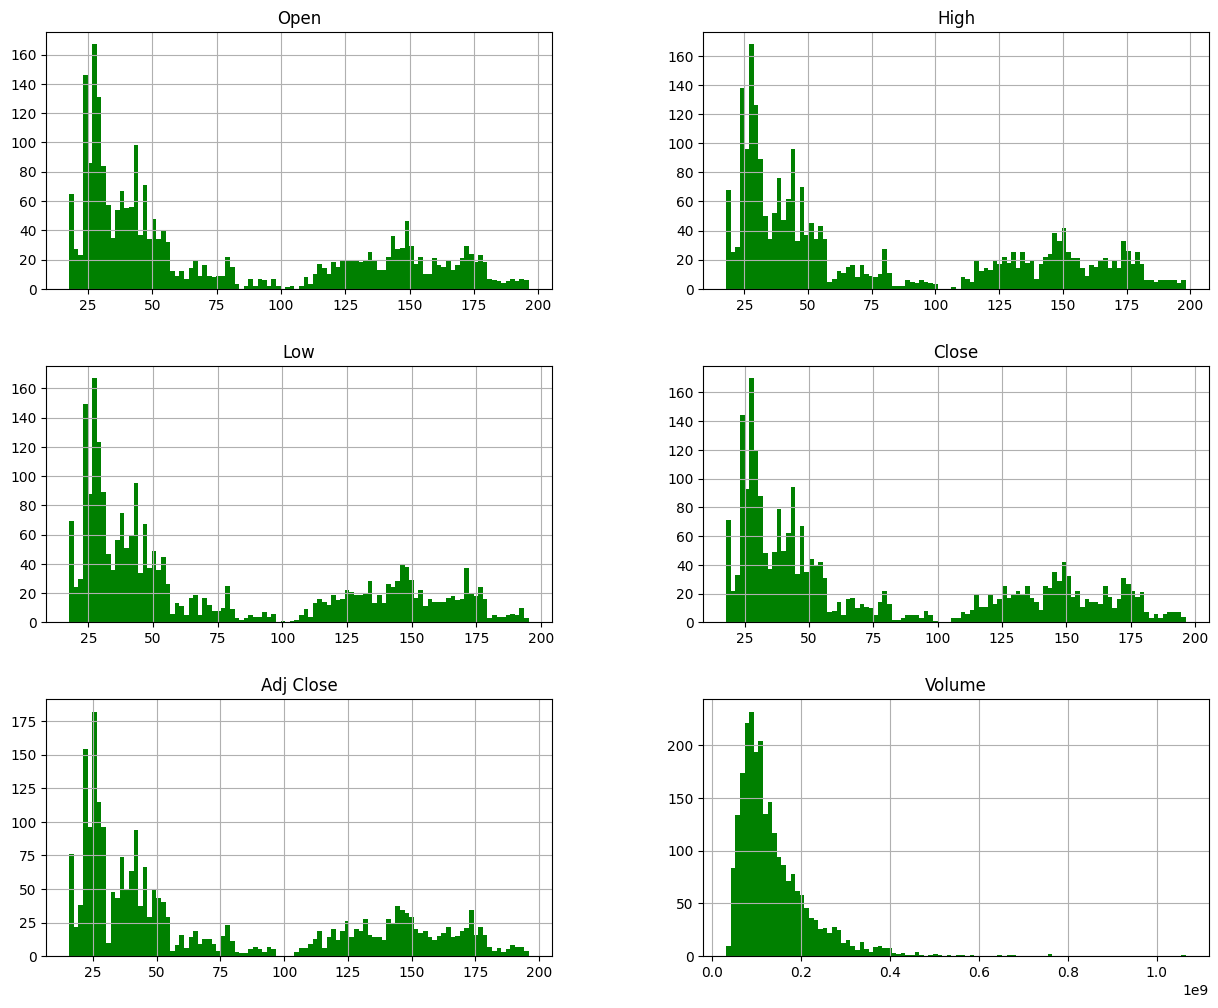

In [405]:
data.hist(bins=100, figsize=(15, 12), color='green')
plt.show()

In [406]:
# DATA SCALLING 
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Close']])

In [409]:
# DATA SPLITTING 
train_size = int(len(data_scaled) * 0.7)
test_size = int(len(data_scaled) * 0.2)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:train_size + test_size]
eval_data = data_scaled[train_size + test_size:]

In [411]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

seq_length = 60
X_train = create_sequences(train_data, seq_length)
X_test = create_sequences(test_data, seq_length)
X_eval = create_sequences(eval_data, seq_length)

In [413]:
# RESHAPING 
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_eval = X_eval.reshape((X_eval.shape[0], X_eval.shape[1], 1))


In [419]:
# Define the LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1))) 
model.add(LSTM(units=50, return_sequences=False)) 
model.add(Dense(units=1))

K.clear_session()

lstm_cb = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=0.01,clipvalue=1.0), loss='mean_squared_error')

lstm_hist = model.fit(X_train, train_data[seq_length:], epochs=100, batch_size=512,
                      validation_data=(X_test, test_data[seq_length:]),  
                      callbacks=[lstm_cb], shuffle=False)
model.summary()

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0032 - val_loss: 0.0378
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0112 - val_loss: 0.1304
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0091 - val_loss: 0.0017
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0053 - val_loss: 0.0074
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0026 - val_loss: 0.0837
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0016 - val_loss: 0.0418
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 5.6769e-04 - val_loss: 0.0019
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0012 - v

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

In [421]:
# Evaluate the model
loss = model.evaluate(X_test, test_data[seq_length:])
print(f"Test Loss: {loss}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1386e-04 
Test Loss: 0.0004271661746315658


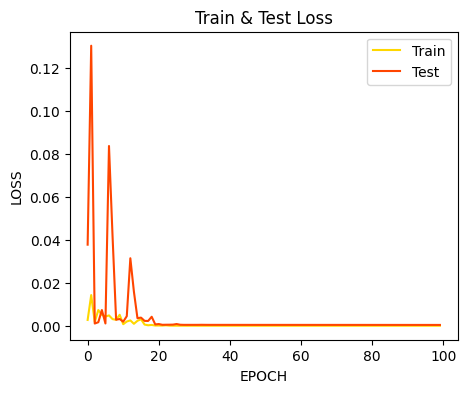

In [423]:
plt.figure(figsize=(5,4))
plt.plot(lstm_hist.history["loss"], label="Train", c="gold")
plt.plot(lstm_hist.history["val_loss"], label="Test", c="orangered")
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.legend()
plt.title("Train & Test Loss")
plt.show()

In [425]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_eval_pred = model.predict(X_eval)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [427]:
y_train_pred = mms.inverse_transform(y_train_pred)
y_test_pred = mms.inverse_transform(y_test_pred)

y_train_actual = mms.inverse_transform(train_data[seq_length:].reshape(-1, 1))  # Actual training values
y_test_actual = mms.inverse_transform(test_data[seq_length:].reshape(-1, 1))  # Actual test values

y_eval_pred = mms.inverse_transform(y_eval_pred)
y_eval_actual = mms.inverse_transform(eval_data[seq_length:].reshape(-1, 1))

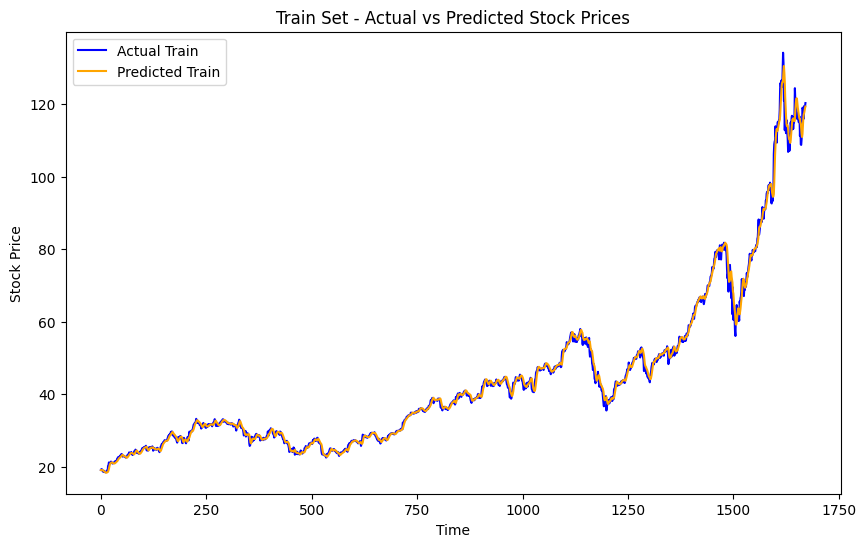

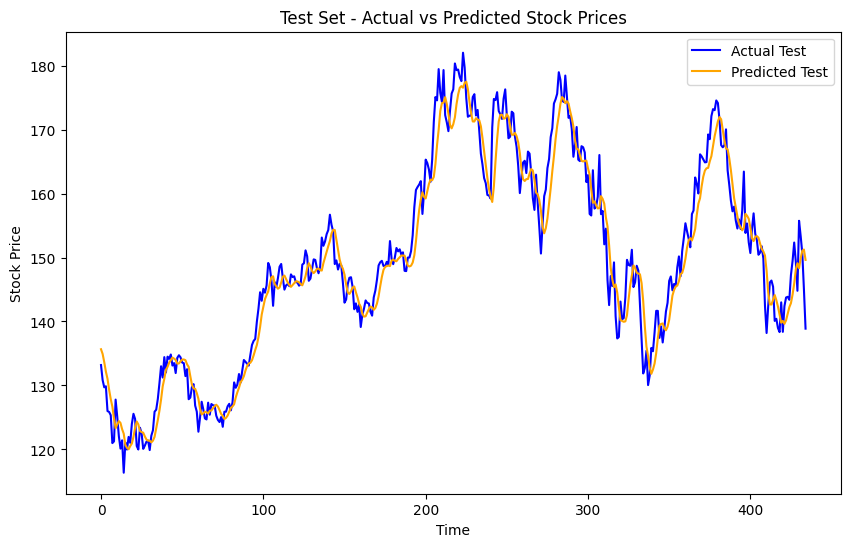

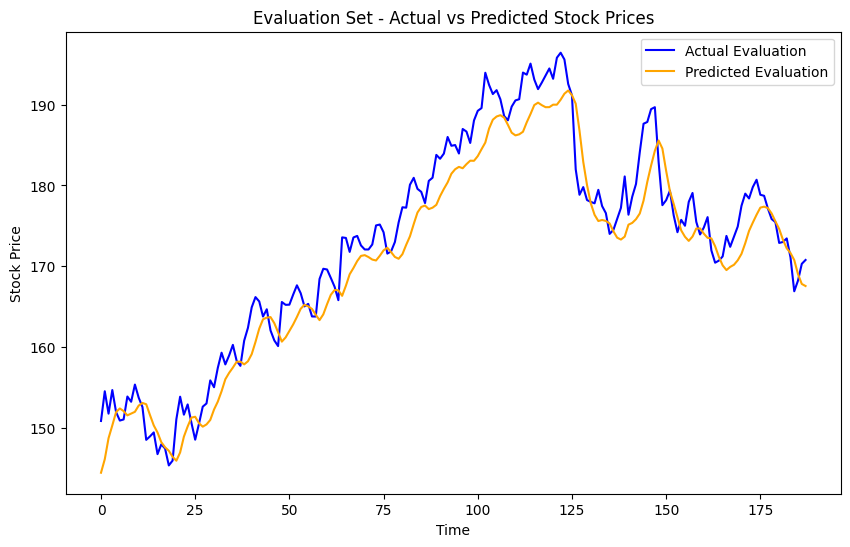

In [429]:
plt.figure(figsize=(10,6))
plt.plot(y_train_actual, label='Actual Train', color='blue')
plt.plot(y_train_pred, label='Predicted Train', color='orange')
plt.title('Train Set - Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(y_test_actual, label='Actual Test', color='blue')
plt.plot(y_test_pred, label='Predicted Test', color='orange')
plt.title('Test Set - Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(y_eval_actual, label='Actual Evaluation', color='blue')
plt.plot(y_eval_pred, label='Predicted Evaluation', color='orange')
plt.title('Evaluation Set - Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [345]:
#train data
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
train_mse = mean_squared_error(y_train_actual, y_train_pred)  # MSE (without sqrt)
train_mape = mean_absolute_percentage_error(y_train_actual, y_train_pred)
train_r2 = r2_score(y_train_actual, y_train_pred)

#test data
test_mae = mean_absolute_error(y_test_actual, y_test_pred)
test_mse = mean_squared_error(y_test_actual, y_test_pred)  # MSE (without sqrt)
test_mape = mean_absolute_percentage_error(y_test_actual, y_test_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

#evaluation data
eval_mae = mean_absolute_error(y_eval_actual, y_eval_pred)
eval_mse = mean_squared_error(y_eval_actual, y_eval_pred)
eval_mape = mean_absolute_percentage_error(y_eval_actual, y_eval_pred)
eval_r2 = r2_score(y_eval_actual, y_eval_pred)

train_result = pd.DataFrame({
    "MAE": [train_mae],
    "MSE": [train_mse],
    "MAPE": [train_mape],
    "R2": [train_r2]
})

test_result = pd.DataFrame({
    "MAE": [test_mae],
    "MSE": [test_mse],
    "MAPE": [test_mape],
    "R2": [test_r2]
})

eval_result = pd.DataFrame({
    "MAE": [eval_mae],
    "MSE": [eval_mse],
    "MAPE": [eval_mape],
    "R2": [eval_r2]
})

train_test_eval_result = pd.concat([train_result, test_result, eval_result], axis=0)
train_test_eval_result.index = ["TRAIN", "TEST", "EVAL"]
train_test_eval_result = train_test_eval_result.round(3)
train_test_eval_result

,MAE,MSE,MAPE,R2
TRAIN,0.723,1.638,0.015,0.997
TEST,2.584,10.907,0.017,0.957
EVAL,2.402,9.107,0.014,0.947


In [371]:
model.add(Dropout(0.2)) 

# Define the Bi-LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1))) 
model.add(Bidirectional(LSTM(units=100, return_sequences=True)))
model.add(LSTM(units=50))

model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mean_squared_error')
lstm_cb = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
lstm_hist = model.fit(X_train, train_data[seq_length:], epochs=100, batch_size=512,
                      validation_data=(X_test, test_data[seq_length:]),
                      callbacks=[lstm_cb], shuffle=False)
model.summary()

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - loss: 0.0075 - val_loss: 0.0393
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.0082 - val_loss: 0.0016
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - loss: 0.0066 - val_loss: 0.0196
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0012 - val_loss: 0.0171
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - loss: 1.9165e-04 - val_loss: 0.0011
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 3.3857e-04 - val_loss: 0.0080
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 1.8381e-04 - val_loss: 0.0022
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 2.5500e-04 - val_loss: 0.0012
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 3.9583e-04 - val_loss: 0.0010
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 1.4076e-04 - val_loss: 0.0020
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 1.3006e-04 - val_loss: 0.0012
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional)      │ (None, 60, 200)             │          81,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50)                  │          50,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 395,555 (1.51 MB)

 Trainable params: 131,851 (515.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 263,704 (1.01 MB)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5693e-04
Test Loss: 0.0005633708788082004


In [ ]:
# Evaluation 
loss = model.evaluate(X_test, test_data[seq_length:])
print(f"Test Loss: {loss}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


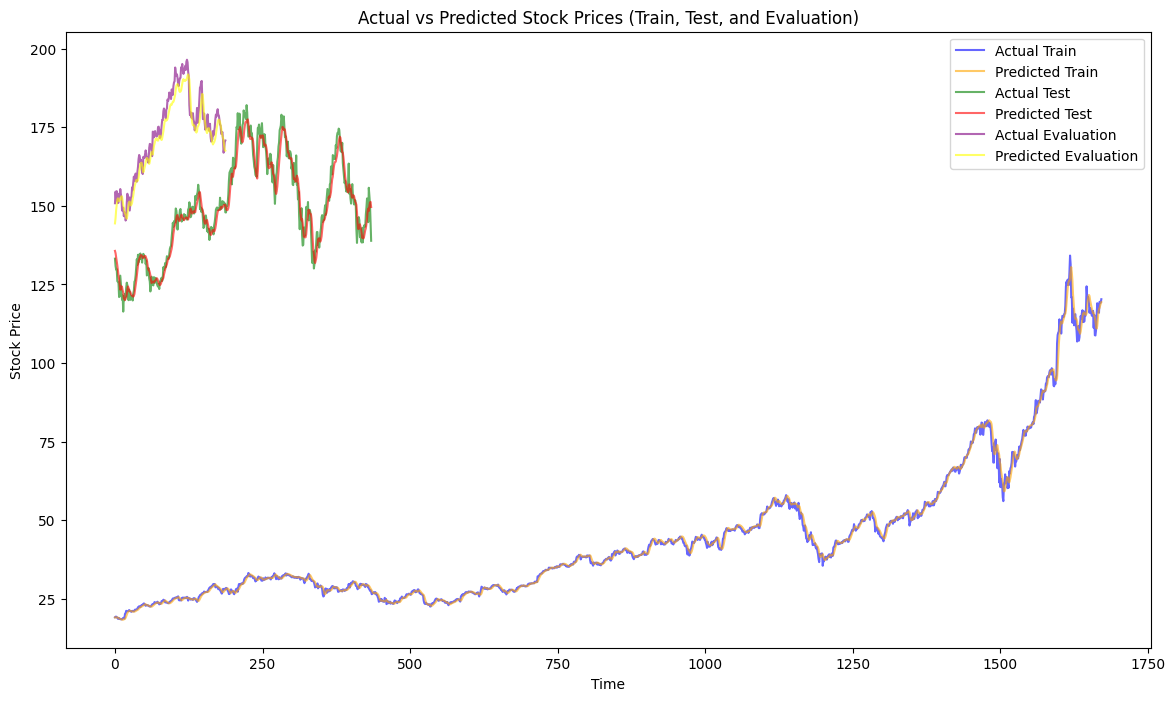

In [431]:
# Make predictions on the train, test, and evaluation data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_eval_pred = model.predict(X_eval)

# Inverse transform the predicted values
y_train_pred = mms.inverse_transform(y_train_pred)
y_test_pred = mms.inverse_transform(y_test_pred)
y_eval_pred = mms.inverse_transform(y_eval_pred)

# Inverse transform the actual values
y_train_actual = mms.inverse_transform(train_data[seq_length:].reshape(-1, 1))
y_test_actual = mms.inverse_transform(test_data[seq_length:].reshape(-1, 1))
y_eval_actual = mms.inverse_transform(eval_data[seq_length:].reshape(-1, 1))

# Visualize predictions 
plt.figure(figsize=(14,8))

plt.plot(y_train_actual, label='Actual Train', color='blue', alpha=0.6)
plt.plot(y_train_pred, label='Predicted Train', color='orange', alpha=0.6)

plt.plot(y_test_actual, label='Actual Test', color='green', alpha=0.6)
plt.plot(y_test_pred, label='Predicted Test', color='red', alpha=0.6)

plt.plot(y_eval_actual, label='Actual Evaluation', color='purple', alpha=0.6)
plt.plot(y_eval_pred, label='Predicted Evaluation', color='yellow', alpha=0.6)

plt.title('Actual vs Predicted Stock Prices (Train, Test, and Evaluation)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [433]:

#train data
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
train_mse = mean_squared_error(y_train_actual, y_train_pred)  # MSE (without sqrt)
train_mape = mean_absolute_percentage_error(y_train_actual, y_train_pred)
train_r2 = r2_score(y_train_actual, y_train_pred)

#test data
test_mae = mean_absolute_error(y_test_actual, y_test_pred)
test_mse = mean_squared_error(y_test_actual, y_test_pred)  # MSE (without sqrt)
test_mape = mean_absolute_percentage_error(y_test_actual, y_test_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

#evaluation data
eval_mae = mean_absolute_error(y_eval_actual, y_eval_pred)
eval_mse = mean_squared_error(y_eval_actual, y_eval_pred)
eval_mape = mean_absolute_percentage_error(y_eval_actual, y_eval_pred)
eval_r2 = r2_score(y_eval_actual, y_eval_pred)

train_result = pd.DataFrame({
    "MAE": [train_mae],
    "MSE": [train_mse],
    "MAPE": [train_mape],
    "R2": [train_r2]
})

test_result = pd.DataFrame({
    "MAE": [test_mae],
    "MSE": [test_mse],
    "MAPE": [test_mape],
    "R2": [test_r2]
})

eval_result = pd.DataFrame({
    "MAE": [eval_mae],
    "MSE": [eval_mse],
    "MAPE": [eval_mape],
    "R2": [eval_r2]
})

train_test_eval_result = pd.concat([train_result, test_result, eval_result], axis=0)
train_test_eval_result.index = ["TRAIN", "TEST", "EVAL"]
train_test_eval_result = train_test_eval_result.round(3)
train_test_eval_result

,MAE,MSE,MAPE,R2
TRAIN,0.799,1.936,0.017,0.996
TEST,2.869,13.626,0.019,0.946
EVAL,3.093,14.276,0.018,0.917
